In [ ]:
# Install necessary libraries
!pip install -q kagglehub torch torchvision matplotlib scikit-learn tensorboard pandas

import torch
import numpy as np
import os

# --- 1. GPU Verification ---
if not torch.cuda.is_available():
    raise RuntimeError("❌ GPU not detected! Please change runtime type to GPU in Google Colab.")

device = torch.device("cuda")
print(f"✅ GPU Detected: {torch.cuda.get_device_name(0)}")

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

✅ GPU Detected: Tesla T4


In [ ]:
import kagglehub

print("\n⬇️ Downloading Flickr30k Dataset via kagglehub...")
dataset_path = kagglehub.dataset_download("eeshawn/flickr30k")
print(f"✅ Flickr30k path: {dataset_path}")

print("\n⬇️ Downloading Word2Vec from Kaggle...")
# Alternative source that is reliable
path_w2v = kagglehub.dataset_download("leadbest/googlenewsvectorsnegative300")
print(f"✅ Word2Vec path: {path_w2v}")


⬇️ Downloading Flickr30k Dataset via kagglehub...
Using Colab cache for faster access to the 'flickr30k' dataset.
✅ Flickr30k path: /kaggle/input/flickr30k

⬇️ Downloading Word2Vec from Kaggle...
Using Colab cache for faster access to the 'googlenewsvectorsnegative300' dataset.
✅ Word2Vec path: /kaggle/input/googlenewsvectorsnegative300


In [ ]:
import os
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

# --- Locate Flickr30k Files ---
image_dir = None
caption_file = None

print(f"🔍 Searching in: {dataset_path}")

for root, dirs, files in os.walk(dataset_path):
    # Locate Image Directory
    if 'flickr30k_images' in dirs:
        image_dir = os.path.join(root, 'flickr30k_images')

    # Locate Caption File (Expanded to include captions.txt)
    for file in files:
        if file.endswith('results.csv') or file.endswith('.token') or file.endswith('captions.txt'):
            caption_file = os.path.join(root, file)

# Validation
if not image_dir:
    raise FileNotFoundError(f"❌ Could not find 'flickr30k_images' folder in {dataset_path}")
if not caption_file:
    # List files to help debug if it fails again
    print("Files found in root:", os.listdir(dataset_path))
    raise FileNotFoundError(f"❌ Could not find a caption file (results.csv, .token, or captions.txt) in {dataset_path}")

print(f"📂 Image Dir: {image_dir}")
print(f"📄 Caption File: {caption_file}")

# --- Locate Word2Vec File ---
word2vec_path = None
# Check the path_w2v variable from Cell 2
for root, dirs, files in os.walk(path_w2v):
    for file in files:
        if file.endswith("GoogleNews-vectors-negative300.bin"):
            word2vec_path = os.path.join(root, file)
            break

# Handle compressed case if necessary
if not word2vec_path:
     for root, dirs, files in os.walk(path_w2v):
        for file in files:
            if file.endswith(".bin.gz"):
                print("⏳ Unzipping Word2Vec...")
                !gunzip -k "{os.path.join(root, file)}"
                word2vec_path = os.path.join(root, "GoogleNews-vectors-negative300.bin")

if not word2vec_path:
    raise FileNotFoundError("Could not find GoogleNews-vectors-negative300.bin")

print(f"🧠 Word2Vec File: {word2vec_path}")

🔍 Searching in: /kaggle/input/flickr30k
📂 Image Dir: /kaggle/input/flickr30k/flickr30k_images
📄 Caption File: /kaggle/input/flickr30k/captions.txt
🧠 Word2Vec File: /kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin


In [ ]:
import pandas as pd
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image

# [cite_start]--- Define Transforms [cite: 23-26] ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# --- Custom Dataset Class (Robust Parser) ---
class Flickr30kDataset(Dataset):
    def __init__(self, root_dir, caption_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.captions = []
        self.images = []

        print(f"🔍 Loading captions from: {caption_file}")

        # Manual parsing is safer for mixed formats than read_csv here
        with open(caption_file, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            # Check header to skip it
            if "image" in lines[0].lower():
                lines = lines[1:]

            for line in lines:
                line = line.strip()
                if not line: continue

                # Try splitting by pipe | first (common in some versions)
                if '|' in line:
                    parts = line.split('|')
                else:
                    # Split by comma, but only on the first comma to separate ImageID
                    parts = line.split(',', 1)

                if len(parts) < 2: continue

                # Extract Image ID (remove extra identifiers like #0, #1 if present)
                image_id = parts[0].strip()
                # If image_id looks like "100.jpg,0", we split again
                if ',' in image_id:
                     image_id = image_id.split(',')[0]

                # Remove #0, #1 suffixes if they exist
                image_id = image_id.split('#')[0].strip()

                # Extract Caption (the rest of the line)
                caption_text = parts[-1].strip()

                # Clean up if caption starts with '0,' or '1,' (comment numbers)
                if len(caption_text) > 2 and caption_text[1] == ',' and caption_text[0].isdigit():
                     caption_text = caption_text[2:].strip()

                self.images.append(image_id)
                self.captions.append(caption_text)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_id = self.images[idx]
        caption = self.captions[idx]
        img_path = os.path.join(self.root_dir, img_id)

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            # print(f"⚠️ Failed to load {img_id}: {e}")
            # If fail, return a random safe item to avoid recursion depth error
            return self.__getitem__((idx + 10) % len(self))

        if self.transform:
            image = self.transform(image)

        return image, caption

# --- Initialize Dataset ---
full_dataset = Flickr30kDataset(image_dir, caption_file, transform=transform)
print(f"✅ Total Valid Samples: {len(full_dataset)}")

if len(full_dataset) == 0:
    raise RuntimeError("Dataset is empty. Check parsing logic.")

# Split 80/20
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
print("✅ DataLoaders Ready.")

🔍 Loading captions from: /kaggle/input/flickr30k/captions.txt
✅ Total Valid Samples: 158915
✅ DataLoaders Ready.


In [ ]:
import struct
import torch
import torch.nn as nn
import numpy as np

# [cite_start]--- Helper Functions (Provided in TP) [cite: 37-50] ---
def read_until(open_file):
    while True:
        char = open_file.read(1)
        if char == b' ': break
        yield char

def read_word2vec(file_path):
    print(f"⏳ Reading Word2Vec binary from: {file_path}")
    try:
        with open(file_path, "rb") as f:
            # Read header: number of words and dimensions
            header = f.readline()
            n_words, n_dim = map(int, header.split())
            print(f"   Header: {n_words} words, {n_dim} dimensions")

            # Read binary data
            for _ in range(n_words):
                word = b''.join(read_until(f)).decode('utf-8', errors='ignore')
                binary_len = struct.calcsize('f') * n_dim
                # unpack float 32 * 300
                vector = struct.unpack('f' * n_dim, f.read(binary_len))
                yield word, vector
    except Exception as e:
        print(f"❌ Error reading Word2Vec file: {e}")
        raise e

# [cite_start]--- 1. Build Vocabulary from Dataset [cite: 29-36] ---
print("🏗️ Building Vocabulary from dataset captions...")
vocab_set = set()

# Iterate through the dataset (now safe thanks to the Cell 4 fix)
for i, (_, caption) in enumerate(full_dataset):
    tokens = caption.lower().strip().split()
    vocab_set.update(tokens)
    if i % 5000 == 0:
        print(f"   Processed {i} captions...")

print(f"✅ Dataset Vocabulary Size: {len(vocab_set)} unique words")

# [cite_start]--- 2. Create Embedding Layer [cite: 51-64] ---
def create_embedding_matrix(vocab_set, file_path):
    # Special tokens
    idx_to_word = ["<pad>", "<start>", "<end>", "<unk>"]
    word_to_idx = {w: i for i, w in enumerate(idx_to_word)}

    # Initialize weights for special tokens (random or zeros)
    weights = [np.zeros((1, 300)) for _ in range(4)]

    print("⏳ Matching Word2Vec embeddings to vocabulary...")
    matches = 0

    # Scan Word2Vec file and pick only words present in our dataset
    for word, vector in read_word2vec(file_path):
        if word in vocab_set and word not in word_to_idx:
            word_to_idx[word] = len(idx_to_word)
            idx_to_word.append(word)
            weights.append(np.array(vector).reshape(1, 300))
            matches += 1

    print(f"✅ Found embeddings for {matches} words.")

    # Create final tensor
    weights_tensor = torch.FloatTensor(np.concatenate(weights, axis=0))

    # Create Embedding Layer (frozen=False allows fine-tuning if needed)
    emb_layer = nn.Embedding.from_pretrained(weights_tensor, freeze=False)

    return emb_layer, idx_to_word, word_to_idx

# Ensure word2vec_path exists (defined in Cell 3)
if 'word2vec_path' not in locals():
    raise NameError("variable 'word2vec_path' is missing. Please re-run Cell 3.")

# Create the embeddings
embedding_layer, idx2word, word2idx = create_embedding_matrix(vocab_set, word2vec_path)

# [cite_start]Move to GPU [cite: 5]
embedding_layer = embedding_layer.to(device)
print(f"✅ Final Model Vocabulary Size: {len(idx2word)}")

# [cite_start]--- 3. Tokenization Utilities [cite: 13, 102] ---
def tokenize(sentence, word_to_idx, max_len=20):
    tokens = [word_to_idx["<start>"]]
    words = sentence.lower().strip().split()
    for w in words:
        # Use <unk> if word is not found
        tokens.append(word_to_idx.get(w, word_to_idx["<unk>"]))
        if len(tokens) >= max_len - 1: break
    tokens.append(word_to_idx["<end>"])

    # Padding
    while len(tokens) < max_len:
        tokens.append(word_to_idx["<pad>"])
    return torch.tensor(tokens)

def untokenize(indices, idx_to_word):
    words = []
    for idx in indices:
        idx = idx.item()
        if idx == word2idx["<end>"]: break
        if idx not in [word2idx["<start>"], word2idx["<pad>"], word2idx["<unk>"]]:
            words.append(idx_to_word[idx])
    return " ".join(words)

print("✅ Tokenizer ready.")

🏗️ Building Vocabulary from dataset captions...
   Processed 0 captions...
   Processed 5000 captions...
   Processed 10000 captions...
   Processed 15000 captions...
   Processed 20000 captions...
   Processed 25000 captions...
   Processed 30000 captions...
   Processed 35000 captions...
   Processed 40000 captions...
   Processed 45000 captions...
   Processed 50000 captions...
   Processed 55000 captions...
   Processed 60000 captions...
   Processed 65000 captions...
   Processed 70000 captions...
   Processed 75000 captions...
   Processed 80000 captions...
   Processed 85000 captions...
   Processed 90000 captions...
   Processed 95000 captions...
   Processed 100000 captions...
   Processed 105000 captions...
   Processed 110000 captions...
   Processed 115000 captions...
   Processed 120000 captions...
   Processed 125000 captions...
   Processed 130000 captions...
   Processed 135000 captions...
   Processed 140000 captions...
   Processed 145000 captions...
   Processed 1500

In [ ]:
# [cite_start]1. Encoder [cite: 68-72]
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        for param in self.resnet.parameters(): param.requires_grad = False

    def forward(self, images):
        features = self.resnet(images)
        features = features.permute(0, 2, 3, 1).view(features.size(0), -1, features.size(1))
        return features

# [cite_start]2. Attention [cite: 73-79]
class Attention(nn.Module):
    def __init__(self, encoder_dim, hidden_dim, attention_dim):
        super(Attention, self).__init__()
        self.W_att = nn.Linear(encoder_dim + hidden_dim, attention_dim)
        self.v_att = nn.Linear(attention_dim, 1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, features, hidden_state):
        seq_len = features.size(1)
        hidden_expanded = hidden_state.unsqueeze(1).repeat(1, seq_len, 1)
        combined = torch.cat((features, hidden_expanded), dim=2)
        attn_weights = self.softmax(self.v_att(torch.tanh(self.W_att(combined))))
        context = torch.sum(attn_weights * features, dim=1)
        return context, attn_weights

# [cite_start]3. Custom LSTM [cite: 80-88]
class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, encoder_dim, attention_dim):
        super(LSTMWithAttention, self).__init__()
        self.attention = Attention(encoder_dim, hidden_size, attention_dim)
        self.hidden_size = hidden_size
        concat_dim = input_size + hidden_size + encoder_dim

        self.W_i = nn.Linear(concat_dim, hidden_size)
        self.W_f = nn.Linear(concat_dim, hidden_size)
        self.W_c = nn.Linear(concat_dim, hidden_size)
        self.W_o = nn.Linear(concat_dim, hidden_size)

    def forward(self, x_t, h_prev, c_prev, encoder_features):
        context, _ = self.attention(encoder_features, h_prev)
        combined = torch.cat((x_t, h_prev, context), dim=1)

        i_t = torch.sigmoid(self.W_i(combined))
        f_t = torch.sigmoid(self.W_f(combined))
        o_t = torch.sigmoid(self.W_o(combined))
        c_tilde = torch.tanh(self.W_c(combined))

        c_t = f_t * c_prev + i_t * c_tilde
        h_t = o_t * torch.tanh(c_t)
        return h_t, c_t

# [cite_start]4. Full Model [cite: 90-91]
class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_layer, hidden_size, vocab_size, attention_dim):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = EncoderCNN()
        self.embedding = embed_layer
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.decoder_cell = LSTMWithAttention(300, hidden_size, 2048, attention_dim)
        self.fc_out = nn.Linear(hidden_size, vocab_size)

    def forward(self, images, captions):
        features = self.encoder(images)
        embedded = self.embedding(captions)
        batch_size, seq_len = captions.shape

        h_t = torch.zeros(batch_size, self.hidden_size).to(device)
        c_t = torch.zeros(batch_size, self.hidden_size).to(device)
        outputs = torch.zeros(batch_size, seq_len, self.vocab_size).to(device)

        for t in range(seq_len):
            h_t, c_t = self.decoder_cell(embedded[:, t, :], h_t, c_t, features)
            outputs[:, t, :] = self.fc_out(h_t)
        return outputs

    def generate(self, image, max_len=20):
        self.eval()
        with torch.no_grad():
            features = self.encoder(image.unsqueeze(0).to(device))
            h_t = torch.zeros(1, self.hidden_size).to(device)
            c_t = torch.zeros(1, self.hidden_size).to(device)
            curr_in = self.embedding(torch.tensor([word2idx["<start>"]]).to(device))

            caption = []
            for _ in range(max_len):
                h_t, c_t = self.decoder_cell(curr_in, h_t, c_t, features)
                pred_idx = self.fc_out(h_t).argmax(1)
                if pred_idx == word2idx["<end>"]: break
                caption.append(pred_idx)
                curr_in = self.embedding(pred_idx)
        return untokenize(caption, idx2word)
print("✅ Model Defined.")

✅ Model Defined.


In [ ]:
# [cite_start]Setup [cite: 92-97]
LEARNING_RATE = 0.001
EPOCHS = 5
model = ImageCaptioningModel(embedding_layer, 512, len(idx2word), 256).to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=word2idx["<pad>"])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
writer = SummaryWriter()

print("🚀 Starting Training...")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for i, (imgs, caps_raw) in enumerate(train_loader):
        imgs = imgs.to(device)
        caps = torch.stack([tokenize(c, word2idx) for c in caps_raw]).to(device)

        optimizer.zero_grad()
        outputs = model(imgs, caps[:, :-1])
        targets = caps[:, 1:]

        loss = criterion(outputs.reshape(-1, len(idx2word)), targets.reshape(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if i % 50 == 0:
             print(f"   Step {i}, Loss: {loss.item():.4f}")
             writer.add_scalar('Loss', loss.item(), epoch * len(train_loader) + i)

    scheduler.step()
    print(f"✅ Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")

    # Generate Example
    test_img, test_cap = test_dataset[np.random.randint(0, len(test_dataset))]
    print(f"🖼️ Orig: {test_cap}")
    print(f"🤖 Pred: {model.generate(test_img)}")
    print("-" * 50)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 188MB/s]


🚀 Starting Training...
   Step 0, Loss: 9.7268
   Step 50, Loss: 5.3411
   Step 100, Loss: 5.1175
   Step 150, Loss: 5.1950
   Step 200, Loss: 4.9451
   Step 250, Loss: 4.8834
   Step 300, Loss: 4.7865
   Step 350, Loss: 4.6888
   Step 400, Loss: 4.4322
   Step 450, Loss: 4.0196
   Step 500, Loss: 4.3544
   Step 550, Loss: 4.5339
   Step 600, Loss: 4.2240
   Step 650, Loss: 4.1856
   Step 700, Loss: 4.1400
   Step 750, Loss: 4.4700
   Step 800, Loss: 4.1074
   Step 850, Loss: 3.9938
   Step 900, Loss: 3.9320
   Step 950, Loss: 4.0294
   Step 1000, Loss: 4.0287
   Step 1050, Loss: 4.0575
   Step 1100, Loss: 4.1531
   Step 1150, Loss: 3.7876
   Step 1200, Loss: 3.8363
   Step 1250, Loss: 3.7596
   Step 1300, Loss: 3.7234
   Step 1350, Loss: 3.7939
   Step 1400, Loss: 3.4701
   Step 1450, Loss: 3.5638
   Step 1500, Loss: 3.5828
   Step 1550, Loss: 3.9793
   Step 1600, Loss: 3.8706
   Step 1650, Loss: 3.4223
   Step 1700, Loss: 3.6081
   Step 1750, Loss: 3.4022
   Step 1800, Loss: 3.3414
 

In [ ]:
#model export
import pickle

# Define paths
MODEL_PATH = "image_captioning_model.pth"
VOCAB_PATH = "vocab.pkl"

print(f"💾 Saving model to {MODEL_PATH}...")
# Save Model State Dict
torch.save(model.state_dict(), MODEL_PATH)

# Save Vocabulary (Critical for consistent tokenization)
with open(VOCAB_PATH, "wb") as f:
    pickle.dump({'word2idx': word2idx, 'idx2word': idx2word}, f)

print("✅ Model and Vocabulary saved successfully.")

💾 Saving model to image_captioning_model.pth...
✅ Model and Vocabulary saved successfully.


In [ ]:
# @title Importing the model (Skip if model already exported and ready)

import pickle

# Check if files exist
if not os.path.exists("image_captioning_model.pth"):
    raise FileNotFoundError("❌ No saved model found. Please train or upload 'image_captioning_model.pth'.")

# 1. Load Vocabulary
print("📖 Loading Vocabulary...")
with open("vocab.pkl", "rb") as f:
    vocab_data = pickle.load(f)
    word2idx = vocab_data['word2idx']
    idx2word = vocab_data['idx2word']

# 2. Re-Initialize Model Architecture
# Ensure these params match your training config!
HIDDEN_DIM = 512
ATTENTION_DIM = 256

print("🏗️ Re-building Model Architecture...")
model = ImageCaptioningModel(
    embed_layer=nn.Embedding(len(idx2word), 300), # Placeholder, weights load next
    hidden_size=HIDDEN_DIM,
    vocab_size=len(idx2word),
    attention_dim=ATTENTION_DIM
).to(device)

# 3. Load Weights
print("🔄 Loading Weights...")
model.load_state_dict(torch.load("image_captioning_model.pth", map_location=device))
model.eval()

print("✅ Model loaded and ready for inference!")

🧪 Running Evaluation on Test Set...


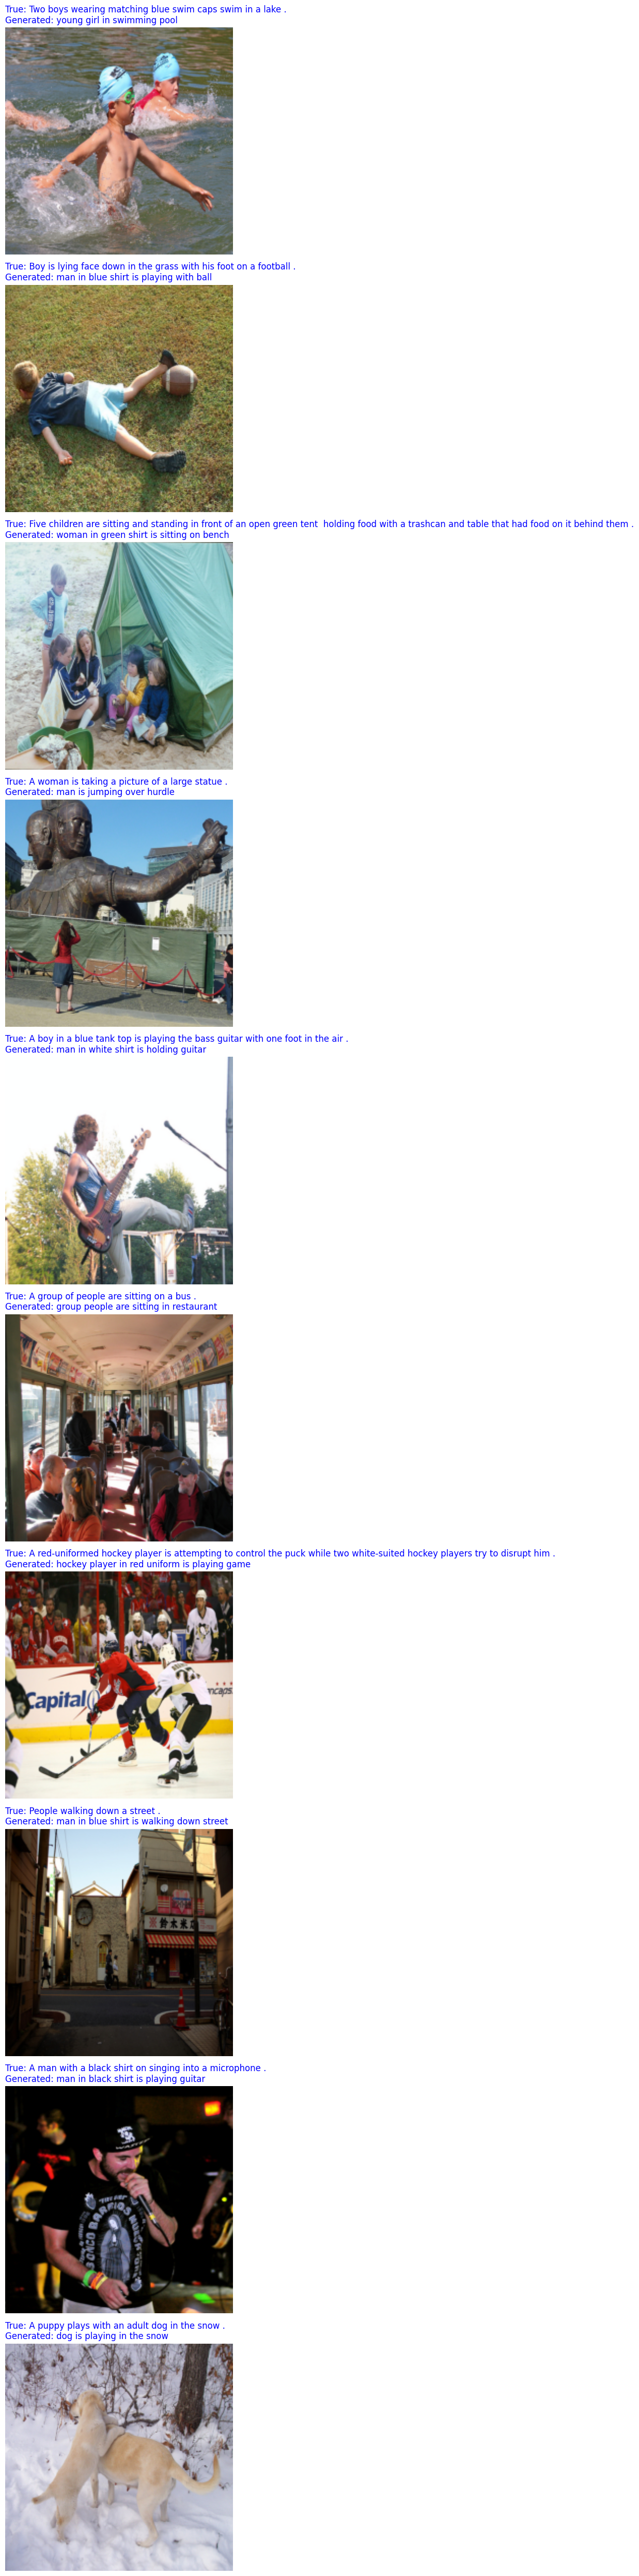

In [ ]:
# testing
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, dataset, num_examples=10):
    model.eval()

    # Create a figure
    fig = plt.figure(figsize=(15, 5 * num_examples))

    for i in range(num_examples):
        # Pick random index
        idx = np.random.randint(0, len(dataset))
        image, true_caption = dataset[idx]

        # Generate Caption (Using the correct method name 'generate')
        # Note: image needs to be (1, 3, 224, 224) on GPU
        gen_caption = model.generate(image.to(device))

        # Un-normalize image for display
        # ImageNet stats: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        img_display = image.permute(1, 2, 0).cpu().numpy()
        img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_display = np.clip(img_display, 0, 1)

        # Plot
        ax = fig.add_subplot(num_examples, 1, i + 1)
        ax.imshow(img_display)
        ax.axis('off')

        # Set titles
        ax.set_title(f"True: {true_caption}\nGenerated: {gen_caption}",
                     fontsize=12, color='blue', loc='left')

    plt.tight_layout()
    plt.show()

print("🧪 Running Evaluation on Test Set...")
evaluate_model(model, test_dataset, num_examples=10)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# [cite_start]1. Redefine LSTM to return attention weights [cite: 88]
class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, encoder_dim, attention_dim):
        super(LSTMWithAttention, self).__init__()
        self.attention = Attention(encoder_dim, hidden_size, attention_dim)
        self.hidden_size = hidden_size
        concat_dim = input_size + hidden_size + encoder_dim

        self.W_i = nn.Linear(concat_dim, hidden_size)
        self.W_f = nn.Linear(concat_dim, hidden_size)
        self.W_c = nn.Linear(concat_dim, hidden_size)
        self.W_o = nn.Linear(concat_dim, hidden_size)

    def forward(self, x_t, h_prev, c_prev, encoder_features):
        # Capture attention weights this time!
        context, attn_weights = self.attention(encoder_features, h_prev)

        combined = torch.cat((x_t, h_prev, context), dim=1)

        i_t = torch.sigmoid(self.W_i(combined))
        f_t = torch.sigmoid(self.W_f(combined))
        o_t = torch.sigmoid(self.W_o(combined))
        c_tilde = torch.tanh(self.W_c(combined))

        c_t = f_t * c_prev + i_t * c_tilde
        h_t = o_t * torch.tanh(c_t)

        # Return weights alongside states
        return h_t, c_t, attn_weights

# [cite_start]2. Redefine Full Model to handle the new return signature [cite: 90]
class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_layer, hidden_size, vocab_size, attention_dim):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = EncoderCNN()
        self.embedding = embed_layer
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.decoder_cell = LSTMWithAttention(300, hidden_size, 2048, attention_dim)
        self.fc_out = nn.Linear(hidden_size, vocab_size)

    def forward(self, images, captions):
        features = self.encoder(images)
        embedded = self.embedding(captions)
        batch_size, seq_len = captions.shape

        h_t = torch.zeros(batch_size, self.hidden_size).to(device)
        c_t = torch.zeros(batch_size, self.hidden_size).to(device)
        outputs = torch.zeros(batch_size, seq_len, self.vocab_size).to(device)

        for t in range(seq_len):
            # Unpack 3 values, ignore weights for training
            h_t, c_t, _ = self.decoder_cell(embedded[:, t, :], h_t, c_t, features)
            outputs[:, t, :] = self.fc_out(h_t)
        return outputs

    def generate(self, image, max_len=20):
        self.eval()
        with torch.no_grad():
            features = self.encoder(image.unsqueeze(0).to(device))
            h_t = torch.zeros(1, self.hidden_size).to(device)
            c_t = torch.zeros(1, self.hidden_size).to(device)
            curr_in = self.embedding(torch.tensor([word2idx["<start>"]]).to(device))

            caption = []
            for _ in range(max_len):
                # Unpack 3 values
                h_t, c_t, _ = self.decoder_cell(curr_in, h_t, c_t, features)
                pred_idx = self.fc_out(h_t).argmax(1)
                if pred_idx == word2idx["<end>"]: break
                caption.append(pred_idx)
                curr_in = self.embedding(pred_idx)
        return untokenize(caption, idx2word)

# 3. Hot-swap the model
print("🔄 Updating model structure...")
# Save current weights
old_state_dict = model.state_dict()

# Create new model instance
new_model = ImageCaptioningModel(embedding_layer, 512, len(idx2word), 256).to(device)

# Load weights (keys are identical, so this works perfectly)
new_model.load_state_dict(old_state_dict)

# Replace the global variable
model = new_model
print("✅ Model patched successfully! You can now run visualization.")

🔄 Updating model structure...
✅ Model patched successfully! You can now run visualization.


👁️ Visualizing Attention...
Original Caption: Men in green and blue play soccer with an audience in mostly blue .


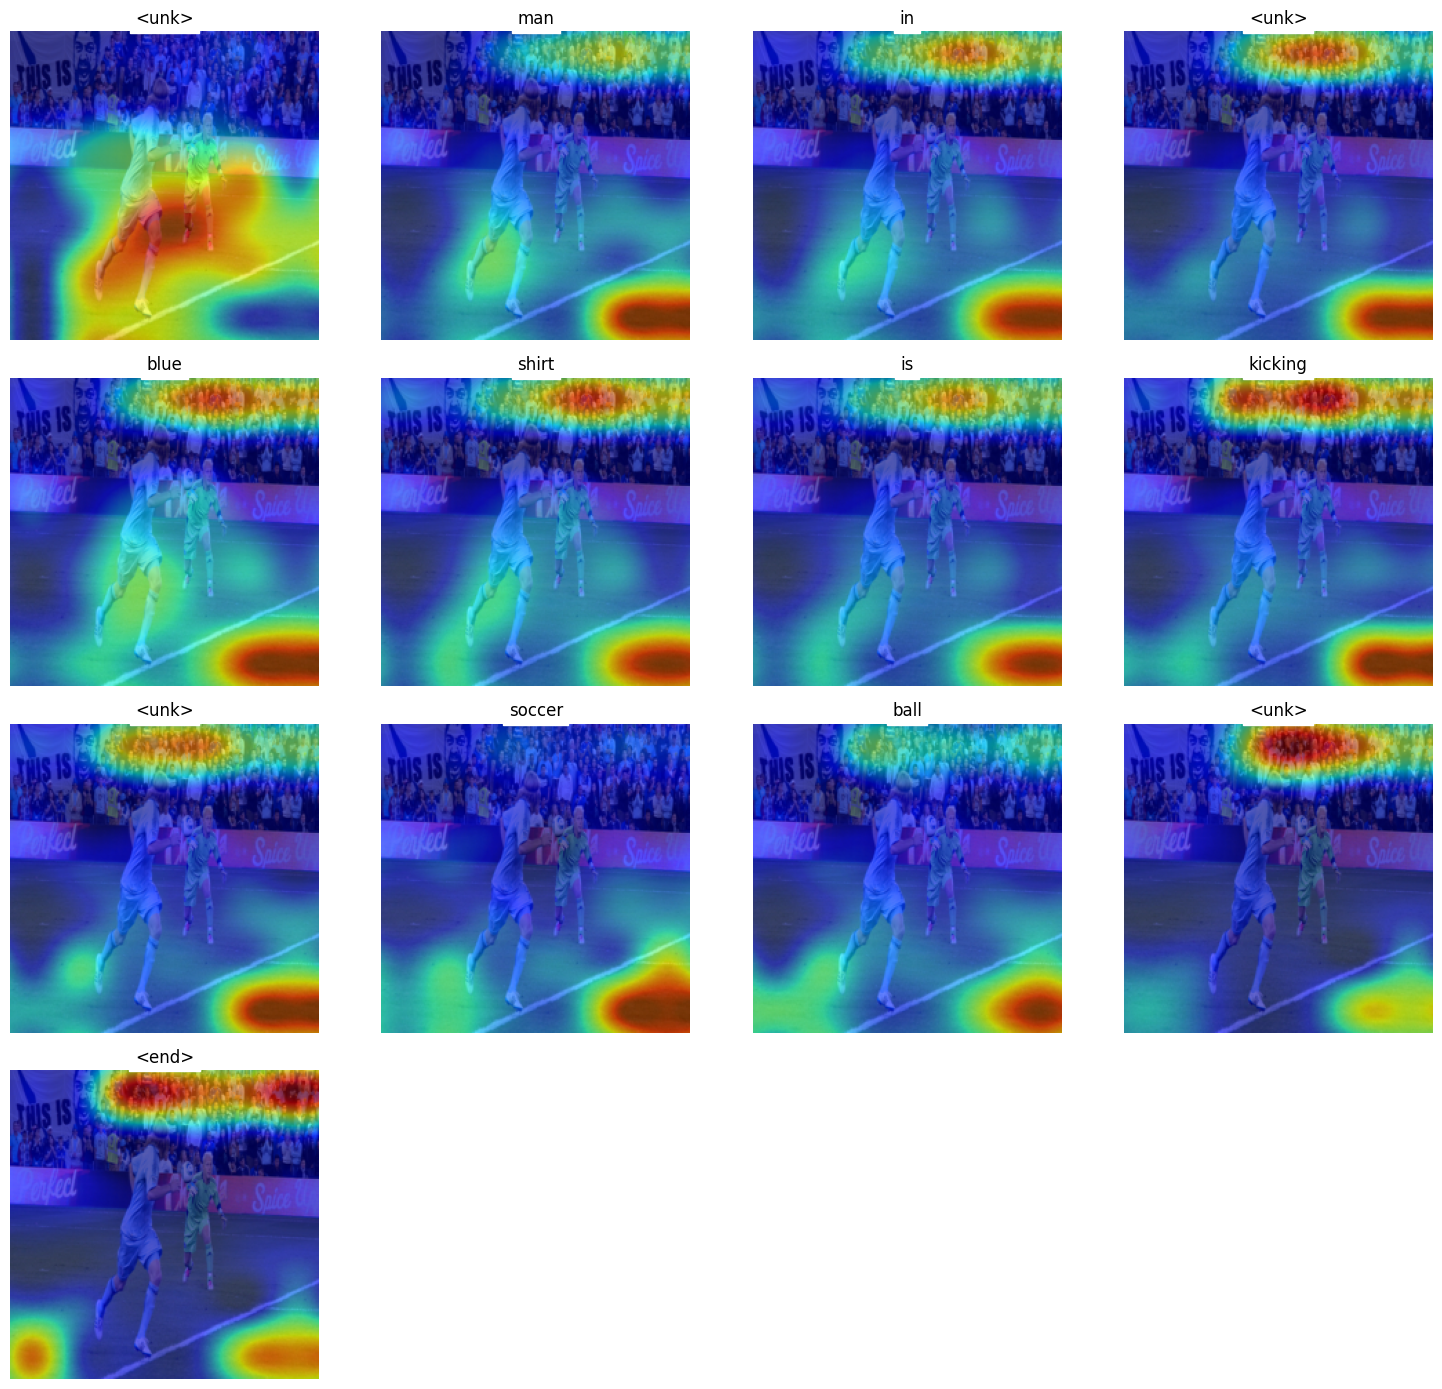

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.transform

def visualize_attention(model, image, word2idx, idx2word, max_len=20):
    model.eval()

    # 1. Prepare Image
    img_tensor = image.unsqueeze(0).to(device)

    with torch.no_grad():
        features = model.encoder(img_tensor)
        h_t = torch.zeros(1, model.hidden_size).to(device)
        c_t = torch.zeros(1, model.hidden_size).to(device)
        curr_in = model.embedding(torch.tensor([word2idx["<start>"]]).to(device))

        generated_words = []
        attention_maps = []

        # 2. Generation Loop
        for _ in range(max_len):
            # Now we capture attn_weights!
            h_t, c_t, attn_weights = model.decoder_cell(curr_in, h_t, c_t, features)

            # Reshape (Batch, 49, 1) -> (7, 7)
            attn_map = attn_weights.view(7, 7).cpu().numpy()
            attention_maps.append(attn_map)

            output = model.fc_out(h_t)
            pred_idx = output.argmax(1).item()

            word = idx2word[pred_idx]
            generated_words.append(word)

            if word == "<end>": break
            curr_in = model.embedding(torch.tensor([pred_idx]).to(device))

    # 3. Visualization Logic
    img_display = image.permute(1, 2, 0).cpu().numpy()
    img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_display = np.clip(img_display, 0, 1)

    num_words = len(generated_words)
    # Handle empty captions
    if num_words == 0:
        print("Model generated empty caption.")
        return

    cols = 4
    rows = (num_words + cols - 1) // cols

    plt.figure(figsize=(15, 3.5 * rows))

    for i, word in enumerate(generated_words):
        plt.subplot(rows, cols, i + 1)

        # Resize attention map to image size
        att_map_resized = skimage.transform.resize(attention_maps[i], (224, 224), order=3)

        plt.imshow(img_display)
        plt.imshow(att_map_resized, alpha=0.6, cmap='jet', interpolation='bilinear')
        plt.axis('off')
        plt.title(word, fontsize=12, backgroundcolor='white')

    plt.tight_layout()
    plt.show()

# Run Visualization
print("👁️ Visualizing Attention...")
rand_idx = np.random.randint(0, len(test_dataset))
sample_img, sample_cap = test_dataset[rand_idx]

print(f"Original Caption: {sample_cap}")
visualize_attention(model, sample_img, word2idx, idx2word)